Title: Converting Nonlinear Classification Problems to Linear Ones
Author: Thomas Breuel
Institution: UniKL

In [2]:

from pylab import *
from numpy import *
def plotfun(f):
    image = zeros((100,100))
    for i in range(100):
        for j in range(100):
            image[i,j] = f(i/100.0,j/100.0)
    imshow(image)

# Nonlinear Classification Problem

Let's consider now a non-linear classification problem.  Here, the decision boundary is described by a quadratic equation.

In [3]:
data = random.uniform(size=(50,2))
lo = ((data[:,0]-0.5)**2+(data[:,1]-0.5)**2<0.15)
hi = logical_not(lo)
sum(lo)

20

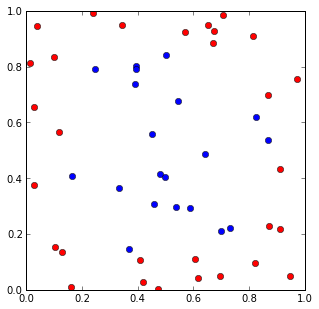

In [4]:
figsize(5,5)
plot(data[lo,0],data[lo,1],'bo')
plot(data[hi,0],data[hi,1],'ro')

We obviously can't solve this problem with a linear classifier.  We could solve it with a quadratic discriminant function

$$g(x,y) = a x^2 + b y^2 + c xy + d x + e y + f$$

Here we use the decision function:

$$D(x,y) = \left\lfloor g(x,y) > 0 \right\rfloor$$

# Linear Classifiers on Nonlinear Transformations of the Data

Optimizing non-linear discriminant functions can be quite difficult.
However, there is a simpler approach that often works,
an extension of a previous trick we used.

In order to turn an inhomogeneous problem $a\cdot x > b$ into a homogeneous
problem $a\cdot x > 0$, we remapped the feature space as $ x \rightarrow (1,x) $.

Let's try a more complicated remapping.

Map the original values $(x,y)$ into a feature space $(x^2,y^2,xy,x,y,1)$
and then perform linear classification in this higher dimensional space.

In [7]:
def phi(v):
    x,y = v
    return array([x**2,y**2,x*y,x,y,1])

Let's try this out; let's transform the input data into the higher dimensional feature space.  We apply the usual sign flip to use the perceptron learning algorithm below.



In [8]:
vs = array([phi(v) for v in data])
vs[lo] = -vs[lo]

For completeness, here is a function that gives us the decision boundary.



In [9]:
def f(x,y):
    return (a[0]*x**2+a[1]*y**2+a[2]*x*y+a[3]*x+a[4]*y+a[5]>0)

Now let's run the perceptron learning algorithm in this larger feature space.


In [10]:
a = random.uniform(size=6)
for epoch in range(100):
    for i in range(len(vs)):
        if dot(a,vs[i])<0: a += vs[i]

If we transform back now, we see that using a linear learning algorithm, we have managed to solve a non-linear classification problem.

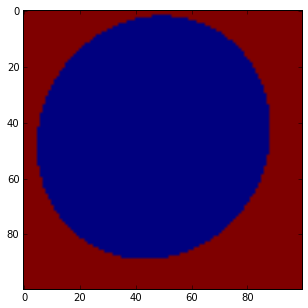

In [11]:
plotfun(f)

# One-Dimensional Analog

Here is a simple one-dimensional analog.
Let's say you want to discriminate values in the range $[0,1]$
from values outside that range.
There is no linear function $f(x)=ax$ such that $ax>0$ iff $x\in[0,1]$.
There is a quadratic function, namely $f(x) = x (1-x)$.

But we can also remap $\xi = (\xi_0,\xi_1) = (x,x^2)$, and in that
new space, there is a linear function, namely $f(\xi) = (1,-1) \cdot \xi$.

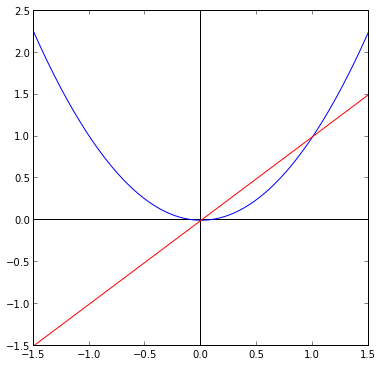

In [11]:
xs = linspace(-1.5,1.5,100)
figsize(6,6)
axvline(x=0,color='black')
axhline(y=0,color='black')
plot(xs,xs**2,'b')
plot(xs,xs,'r')

In this graph, think of the curve not as a plot of a function of one variable,
but instead as set of points in 2D that happens to have a simple correspondence
to points on the $x$ axis.
By making that set curved, we can now "cut off" a region that, when mapped back to the
$x$ axis corresponds to the interval $[0,1]$.

# The Kernel Trick

If we carry out the perceptron learning algorithm in terms of nonlinear functions of the input $\phi(x)$,
then there is only one statement actually involving the data:

$\hbox{if } a\cdot \phi(x) \lt 0 \hbox{ then } a \leftarrow a+\phi(x)$

This comprises the comparison and the weight update.

(rewriting the dot product)

Note that all we ever add to the weight vector $a$ is copies of $\phi(x)$, where $x$ is
a training sample.

$a = \sum_j \lambda_j \phi(x_j)$

Remember that all the training samples are known.
If we plug this in above, we get for training sample $x_i$:

$\hbox{if } \sum\lambda_j \phi(x_j) \cdot \phi(x_i)\lt 0 \hbox{ then } a \leftarrow a+\phi(x_i)$

(updating the lambda)

Instead of updating the weight vector, we can therefore also simply keep track of how often we added $\phi(x_i)$ to the weight vector:

$\hbox{if } \sum \lambda_j \phi(x_j) \cdot \phi(x_i)\lt 0 \hbox{ then } \lambda_i \leftarrow \lambda_i+1 $


(using the inner product)

Looking at the first expression, we don't even need to evaluate the dot product again and again.
All we really need to keep track of is the value $K_{ji} = \phi(x_j)\cdot\phi(x_i)$.

$\hbox{if } \sum \lambda_j K_{ji}\lt 0 \hbox{ then } \lambda_i \leftarrow \lambda_i+1 $

(implicit high dimensional space)

That is very nice because we can use a function $\phi(x)$ that transforms into a very high dimensional
space, but we never need to represent the values in that space.  All we need to do is define the
values of the dot products.

We define these values in terms of a _kernel function_:

$$k(u,v) = \phi(u) \cdot \phi(v)$$

In [12]:
# kernel function
def k(u,v):
    return dot(phi(u),phi(v))

In fact, we can precompute all the dot products:


In [13]:
n = len(data)
ks = zeros((n,n))
for i in range(n):
    for j in range(n):
        ks[i,j] = k(data[i],data[j])

Now, with these ideas, we can write the kernelized perceptron learning algorithm as follows:


In [14]:
c = zeros(len(vs))
for epoch in range(1000):
    for i in range(n):
        sign = (dot(c,ks[:,i])>=0)
        if lo[i] and not sign: c[i] += 1
        elif not lo[i] and sign: c[i] -=  1

In [15]:
c[:10]

array([   2.,  -29.,  -26.,  -63.,   -1., -141.,  322., -397.,  102.,  230.])

We can express the discriminant function directly in terms of the kernel and the $\lambda_i$:

$$g(x) = \sum \lambda_i k(v_i,x) >0$$

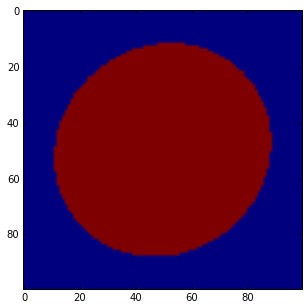

In [16]:
def g(x,y):
    kv = [k(data[i],array([x,y])) for i in range(n)]
    return dot(c,kv)>0
clf(); plotfun(g)

We can also reconstruct the original parameter values directly.



In [17]:
a = sum([c[i] * phi(data[i]) for i in range(n)],axis=0)
a

array([-26.50513205, -25.7265693 ,  -3.92491033,  28.34359676,
        27.40297646, -10.        ])

We see that these parameters give us the same decision region as before.

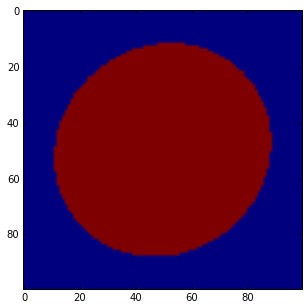

In [18]:
plotfun(f)

# Other Kernels

There is no real reason to construct kernels from a $\phi(x)$ function; we can actually just construct kernels directly.  Each choice of a kernel function determines a particular feature space.

A commonly used kernel is the Gaussian kernel:

$$k(u,v) = c \cdot e^{-\frac{||u-v||^2}{2\sigma^2}}$$

In [19]:
# Gaussian kernel
def k(u,v,sigma=0.1):
    d2 = sum((u-v)**2)
    return exp(-d2/2/sigma**2)

Let's look at this kernel directly.


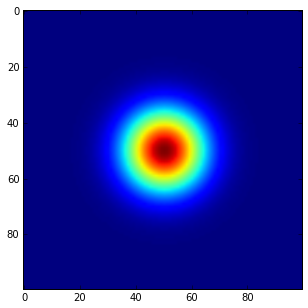

In [20]:
def h(x,y): return k(array([x,y]),array([0.5,0.5]))
plotfun(h)

We precompute all the dot products, as before.



In [21]:
n = len(data)
ks = zeros((n,n))
for i in range(n):
    for j in range(n):
        ks[i,j] = k(data[i],data[j])

Let's look at the dot products.

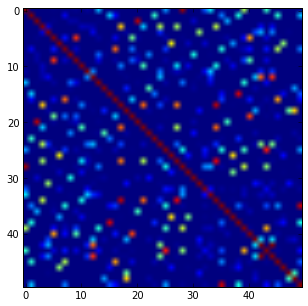

In [22]:
imshow(ks)

Now we run the perceptron learning algorithm on these dot products again.



In [23]:
c = zeros(len(vs))
for epoch in range(1000):
    for i in range(n):
        sign = (dot(c,ks[:,i])>=0)
        if lo[i] and not sign: c[i] += 1
        elif not lo[i] and sign: c[i] -=  1

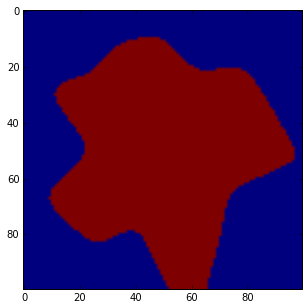

In [24]:
def g(x,y):
    kv = [k(data[i],array([x,y])) for i in range(n)]
    return dot(c,kv)>0
plotfun(g)

Note that we really only need to compute the kernel function for vectors that make a non-zero contribution to the discriminant function; this can result in substantial savings.



In [25]:
len(c),sum(c!=0)

(50, 16)

# Complexity of Decision Regions

However, we have a problem now.  The decision region shown above is 
very complicated, far more than it should be.
We have seen effects like this as overtraining.

The reason is that the feature space induced by the Gaussian kernel
is very high dimensional and many different sets of points are separable in it.
We can control this in one of two ways.

- First, we can adjust the $\sigma$ parameter; 
larger $\sigma$ correspond to smoother decision boundaries.  
- Second, we can limit the number of vectors that make non-zero 
contributions to the discriminant function.

Support vector machine learning algorithms take both approaches.

50 29


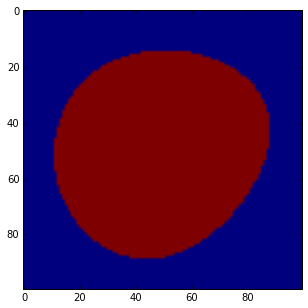

In [26]:
# kernel learning with larger sigma
def k(u,v,sigma=0.5):
    d2 = sum((u-v)**2)
    return exp(-d2/2/sigma**2)
n = len(data)
ks = zeros((n,n))
for i in range(n):
    for j in range(n):
        ks[i,j] = k(data[i],data[j])
c = zeros(len(vs))
for epoch in range(1000):
    for i in range(n):
        sign = (dot(c,ks[:,i])>=0)
        if lo[i] and not sign: c[i] += 1
        elif not lo[i] and sign: c[i] -= 1
print len(c),sum(c!=0)
def g(x,y):
    kv = [k(data[i],array([x,y])) for i in range(n)]
    return dot(c,kv)>0
plotfun(g)